In [42]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pickle # for hacky deep copy
import random
from numpy import genfromtxt
random.seed(2705)

# Project introduction:
## 1. Environment: a maze
A simple maze with 10x10 cells in default setting (scalable), with some cells are "Wall". The wall was put manually at first for testing. After that, I intened to make a function to generate wall randomly. However, to change the walls randomly, I need another algorithm to make sure the maze is solvable (randomized walls can some time blocks the door). Therefore, in this maze, the wall was manually put by hand in the way that guarantee the maze is always solvable.
    
    
The **agent** start at "start_position", which is random generated. First, the agent need to move to get the "key", which is also random generated, then, with the key in hand, finally the agent can exit the maze by going to the "door", which is also random generated.
    
    
The agent has four posibile **action**, going UP, DOWN, LEFT, RIGHT. If the agent want to move to the wall, or to the border of the maze, the agent return to its previous position.

## 2. Algorithm: Sarsa (on-policy TD control)
(In file 01-Maze_SARSA_TD_Control)
## 3.  Algorithm: Sarsa with binary features and Linear Function Approximation
### 3.1 Testing with number of features less than all possible features

In this exercise, I'm using the algorithm in the Reinforcement Learning book, by Richard Sutton and Andrew Barto on page 305. However, I don't use elibible trace. There's a version for that formula without eligible trace at https://artint.info/2e/html/ArtInt2e.Ch12.S9.SS1.html.

To cover all the possible cases in this maze, I believe I must use 800 features:
1. All posible position $= 10x10 = 100$
2. All posible actions = 4, so all possible actions for all position $= 4x100 = 400$
3. With key or without key = 2, so all possible action for all position, with the key info $= 2x400 = 800$

What I want to do in this exercise, is to use less than 800 features to see if it can solve or converge at some point. I use one feature to check if agent have the key or not, and 400 features to check all the position and actions of agent. I added some more feature to solve the problem of agent getting stuck (it can't not decide to go up or down)

I keep train the model, and it take a really long time (since I use a very small value for gradient descent). At the end of the project, I trained the model for more than 2 days, with total episode = 40,000

The result of the test is at the end of this file

In [43]:
TRAIN = False #Train the model or not
rows_count = 10
columns_count = 10
terminating = [(rows_count-1, columns_count-1)]
DOOR = "D"
START = "S"
EMPTY = "E"
WALL = "W"
KEY = "K"
PATH = "P"
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
stepcost = -1
ACTION_LIST = ["UP", "DOWN", "LEFT", "RIGHT"]


def generateTestMaze():
    V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    V.fillna(EMPTY, inplace=True)
    V.iloc[0][1] = WALL
    V.iloc[1][1] = WALL
    V.iloc[2][1] = WALL
    
    V.iloc[4][0] = WALL
    V.iloc[4][1] = WALL
    V.iloc[4][2] = WALL
    V.iloc[4][3] = WALL
    
    V.iloc[7][0] = WALL
    V.iloc[7][1] = WALL
    V.iloc[7][2] = WALL
    V.iloc[7][4] = WALL
    V.iloc[7][5] = WALL
    V.iloc[7][6] = WALL
    
    V.iloc[0][7] = WALL
    V.iloc[1][7] = WALL
    V.iloc[2][7] = WALL
    V.iloc[3][7] = WALL
    V.iloc[4][7] = WALL
    V.iloc[5][7] = WALL
    V.iloc[6][7] = WALL
    
    V.iloc[0][8] = KEY
    V.iloc[rows_count-1][columns_count-1] = DOOR
    V.iloc[0][0] = START
    return V
    

maze = generateTestMaze()
print(maze)

   0  1  2  3  4  5  6  7  8  9
0  S  W  E  E  E  E  E  W  K  E
1  E  W  E  E  E  E  E  W  E  E
2  E  W  E  E  E  E  E  W  E  E
3  E  E  E  E  E  E  E  W  E  E
4  W  W  W  W  E  E  E  W  E  E
5  E  E  E  E  E  E  E  W  E  E
6  E  E  E  E  E  E  E  W  E  E
7  W  W  W  E  W  W  W  E  E  E
8  E  E  E  E  E  E  E  E  E  E
9  E  E  E  E  E  E  E  E  E  D


(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

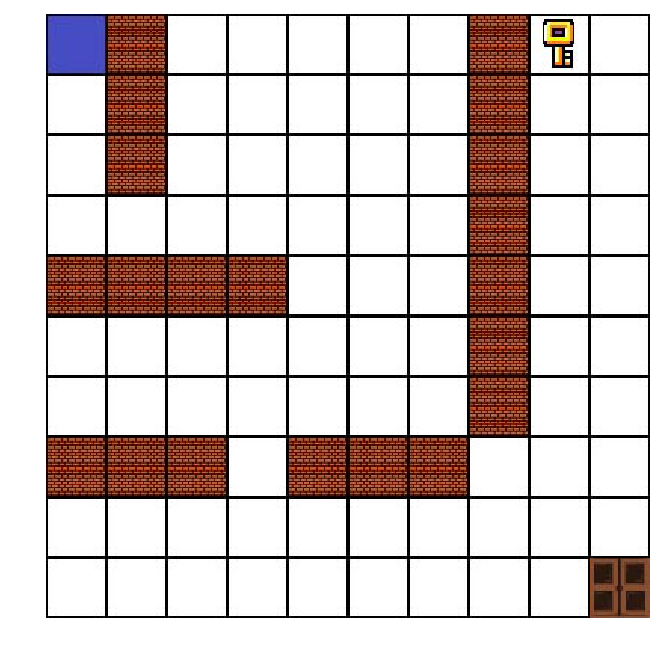

In [44]:
def arrayToImage(array, ncols=10):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


def makeImageArray(dataframe):
    imageArray = np.array([np.asarray(Image.open('images/path.jpg').convert('RGB'))])
    for i in range(rows_count):
        for j in range(columns_count):
            #skip the first cell, since we already add it in the begining
            if (i!=0) or (j!=0):                
                path = "images/empty.jpg"
                if dataframe.iloc()[i][j] == WALL:
                    path = "images/wall.jpg"
                elif dataframe.iloc()[i][j] == DOOR:
                    path = "images/door.jpg"
                elif dataframe.iloc()[i][j] == PATH:
                    path = "images/path.jpg"
                elif dataframe.iloc()[i][j] == KEY:
                    path = "images/key.jpg"
                imageArray = np.append(imageArray, [np.asarray(Image.open(path).convert('RGB'))], axis=0)
    return imageArray

def showMaze(array):
    print(array.shape)
    result = arrayToImage(array)
    plt.figure(2)
    fig=plt.figure(figsize=(8, 8), dpi = 100)
    plt.imshow(result)
    plt.axis('off')    
    plt.show()        

array = makeImageArray(maze)
showMaze(array)

<Figure size 432x288 with 0 Axes>

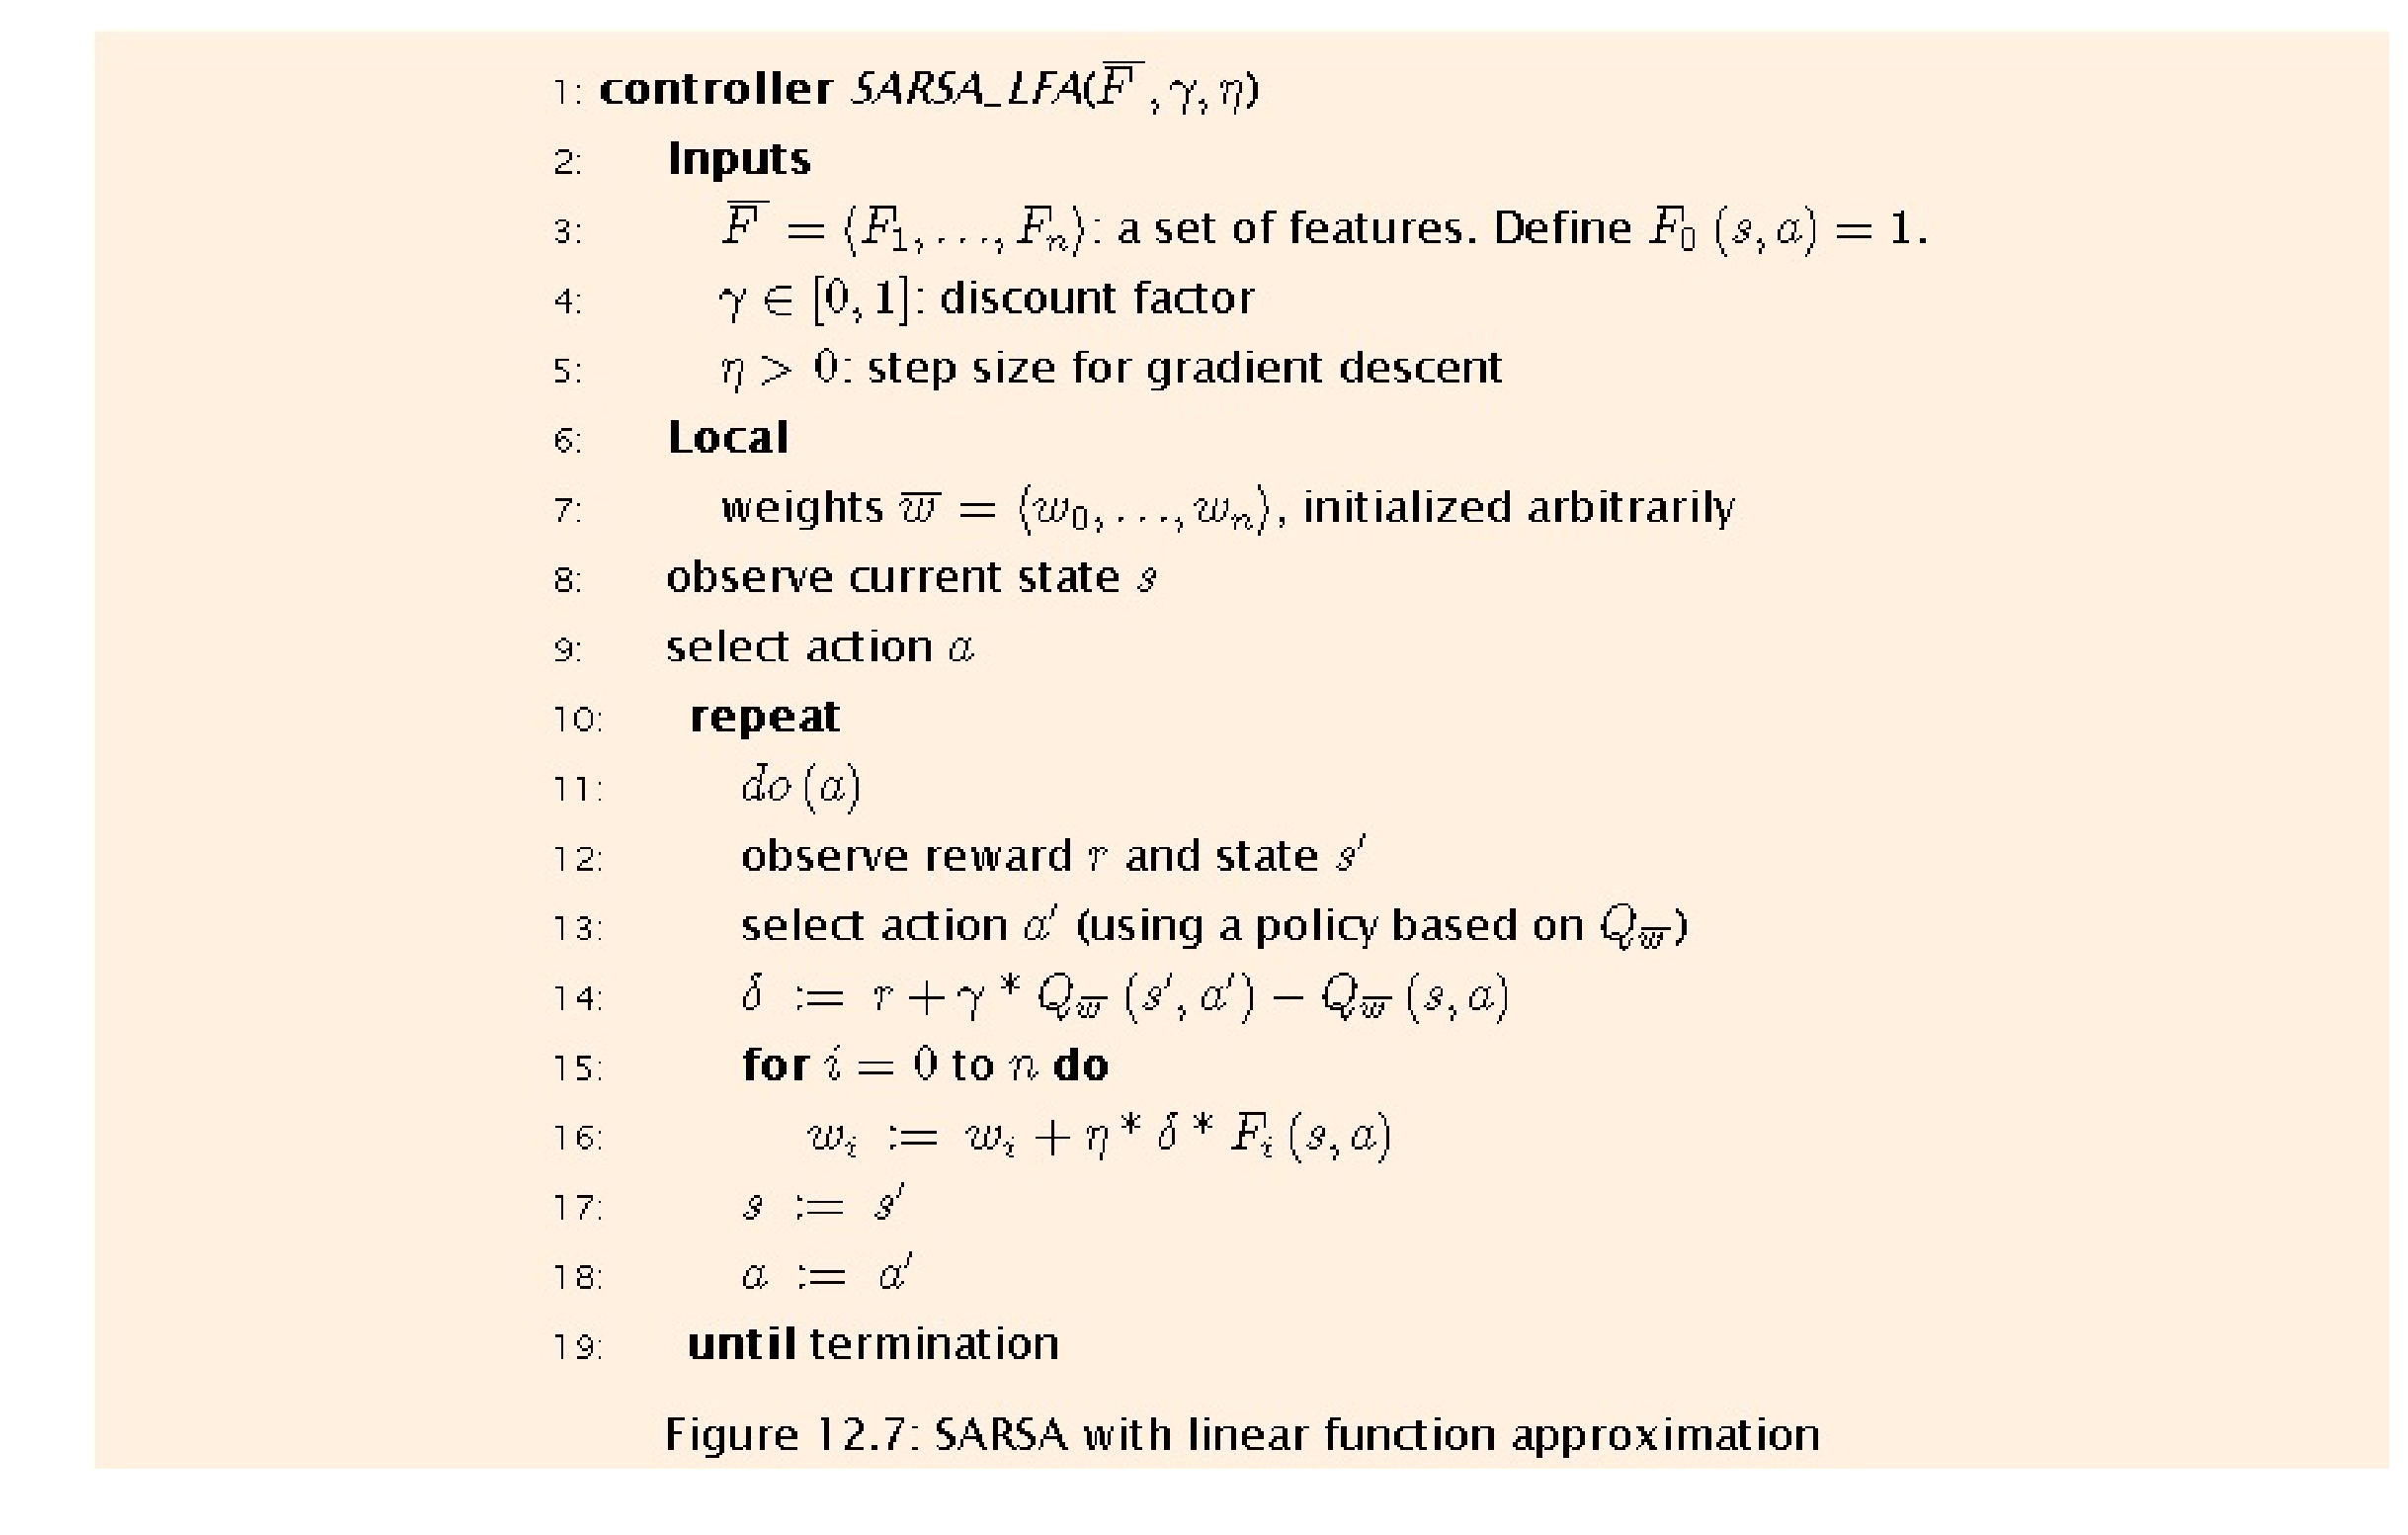

In [45]:
#Formular print
#from: https://artint.info/2e/html/ArtInt2e.Ch12.S9.SS1.html
image = Image.open('sarsaLFA_pseudo.jpg')
plt.figure(2)
fig=plt.figure(figsize=(15, 15), dpi = 200)
plt.imshow(image)
plt.axis('off')
plt.show()


In [46]:
def isWall(row, column, action, baseMaze):
    """
    Return True if action hit the Wall (or boundaries) of the maze
    """
    hitWall = False
    if (action == UP):
        actionRow = row-1
        actionColumn = column
    elif (action == DOWN) :
        actionRow = row+1
        actionColumn = column
    elif (action == LEFT) :
        actionRow = row
        actionColumn = column-1
    elif (action == RIGHT) :
        actionRow = row
        actionColumn = column+1
        
    if (actionRow not in range(rows_count)) or (actionColumn not in range(columns_count)):
        hitWall = True
        
    if (not hitWall):
        if (maze.iloc()[actionRow][actionColumn]) == "W":
            hitWall = True
    return hitWall

def validMoves(row, column, action):    
    """
    :param row
    :param column
    :param action
    
    Make sure that the action don't make you step out of the array bondary [0, rows_count-1] or [0, columns_count-1]
    Some codes look like it doesn't do anything (actionColumn = max(column, 0)), but it actually does something
    in other scenario (column was change because of "Wind blow left", so just leave it there)
    """
    
    if (action == UP):
        actionRow = max(min(row-1, rows_count-1), 0)
        actionColumn = max(min(column, columns_count-1),0)
    elif (action == DOWN) :
        actionRow = max(min(row+1, rows_count-1),0)
        actionColumn = max(min(column, columns_count-1),0)
    elif (action == LEFT) :
        actionRow = max(min(row, rows_count-1),0)
        actionColumn = max(column-1, 0)
    elif (action == RIGHT) :
        actionRow = max(min(row, rows_count-1),0)
        actionColumn = max(min(column+1, columns_count-1),0)
        
    return actionRow, actionColumn
    
def getKey(row, column, action, baseMaze, key):
    result = False
    actionRow, actionColumn = validMoves(row, column, action)
    if (baseMaze.iloc()[actionRow][actionColumn] == KEY) and (key == 0):
        result = True
    return result

def isExit(row, column, action, baseMaze, key):
    result = False
    actionRow, actionColumn = validMoves(row, column, action)
    if (baseMaze.iloc()[actionRow][actionColumn] == DOOR) and (key == 1):
        result = True
    return result
    

def generateFeatures(row, column, action, baseMaze, key):
    """
    Return a binary features array list, depend on state S(row, column), action a, and the maze
    Total features:
    Feature 0: 1
    Feature 1: 1 if action a take the agent into wall, else 0
    Feature 2: 1 if keys < 0, and action move to key, else 0
    Feature 3: 1 if already has keys, and action move to door, else 0
    Feature 4: 1 if doesn't has keys, and action move to door, else 0    
    Feature 5: 1 if has keys else 0    
    Feature 6: 1 if doesn't has keys else 0 
    """


    noFeatures = 35+400
    #noFeatures = 23+100
    featuresArray =  np.ones(noFeatures)
    featuresArray[1] = 1 if isWall(row, column, action, baseMaze) else 0
    featuresArray[2] = 1 if getKey(row, column, action, baseMaze, key) else 0
    featuresArray[3] = 1 if isExit(row, column, action, baseMaze, key) else 0
    featuresArray[4] = 1 if isExit(row, column, action, baseMaze, 1 if (key == 0) else 0) else 0
    featuresArray[5] = 1 if (key == 1) else 0
    featuresArray[6] = 1 if (key == 0) else 0
    featuresArray[7] = 1 if ((row == 0) and (column == 9) and (action == LEFT) and (key == 1)) else 0
    featuresArray[8] = 1 if ((row == 0) and (column == 9) and (action == LEFT) and (key == 0)) else 0
    featuresArray[9] = 1 if ((row == 0) and (column == 8) and (action == RIGHT) and (key == 1)) else 0
    featuresArray[10] = 1 if ((row == 0) and (column == 8) and (action == DOWN) and (key == 1)) else 0
    featuresArray[11] = 1 if ((row == 1) and (column == 8) and (action == UP) and (key == 1)) else 0
    featuresArray[12] = 1 if ((row == 1) and (column == 8) and (action == UP) and (key == 0)) else 0
    featuresArray[13] = 1 if ((row == 8) and (column == 9) and (action == LEFT) and (key == 0)) else 0
    featuresArray[14] = 1 if ((row == 8) and (column == 8) and (action == RIGHT) and (key == 0)) else 0
    
    for i in range(rows_count*columns_count*4):
        if (i==(row*40 + column*4 + action)):
            featuresArray[i+15] = 1
        else: 
            featuresArray[i+15] = 0
            
    featuresArray[423] = 1 if ((row == 8) and (column == 8) and (action == DOWN) and (key == 0)) else 0
    featuresArray[424] = 1 if ((row == 8) and (column == 8) and (action == DOWN) and (key == 1)) else 0
    featuresArray[425] = 1 if ((row == 7) and (column == 8) and (action == DOWN) and (key == 0)) else 0
    featuresArray[426] = 1 if ((row == 7) and (column == 8) and (action == DOWN) and (key == 1)) else 0
    featuresArray[427] = 1 if ((row == 6) and (column == 8) and (action == DOWN) and (key == 0)) else 0
    featuresArray[428] = 1 if ((row == 6) and (column == 8) and (action == DOWN) and (key == 1)) else 0
    featuresArray[429] = 1 if ((row == 5) and (column == 8) and (action == DOWN) and (key == 0)) else 0
    featuresArray[430] = 1 if ((row == 5) and (column == 8) and (action == DOWN) and (key == 1)) else 0
    featuresArray[431] = 1 if ((row == 4) and (column == 8) and (action == DOWN) and (key == 0)) else 0
    featuresArray[432] = 1 if ((row == 4) and (column == 8) and (action == DOWN) and (key == 1)) else 0
    featuresArray[431] = 1 if ((row == 3) and (column == 8) and (action == UP) and (key == 0)) else 0
    featuresArray[432] = 1 if ((row == 3) and (column == 8) and (action == UP) and (key == 1)) else 0
    featuresArray[433] = 1 if ((row == 6) and (column == 8) and (action == RIGHT) and (key == 0)) else 0
    featuresArray[434] = 1 if ((row == 6) and (column == 8) and (action == RIGHT) and (key == 1)) else 0
    
    return featuresArray   

def getQwValue(features_array, weight):
    resultArray = [a*b for a,b in zip(weight,features_array)]
    return sum(resultArray)


def bestAction(weight, row, column, baseMaze, key):
    """
    Select the best action based on Qw
    """ 
    action = UP
    featuresArray = generateFeatures(row, column, action, baseMaze, key)
    bestQ = getQwValue(featuresArray, weight)
    bestAction = UP
    #print("UP: {}".format(bestQ))
    #Loop through all possible actions
    for action in (DOWN, LEFT, RIGHT):
        featuresArray = generateFeatures(row, column, action, baseMaze, key)
        qValue = getQwValue(featuresArray, weight)
        #print(qValue)
        
        #if the action yield better qValue, choose it
        if (bestQ < qValue):
            bestQ = qValue
            bestAction = action
    
    #print(bestQ, bestAction)
    
    return bestAction        
  
def epsilon_greedy_Qw(weight, row, column, baseMaze, key, epsilon):        
    """
    Determine to act greedy for choose random action
    """  
    if np.random.rand() < epsilon:
        actIndex = bestAction(weight, row, column, baseMaze, key) 
    else:        
        actIndex = random.choice([UP, DOWN, LEFT, RIGHT])    
    
    return actIndex



def valueForMaze(row, column, action, baseMaze, key): 
    """
    :param row
    :param column
    :param action
    :param maze
    
    Return the reward of the action
    """
    reward = -0.1
    
    if(isWall(row, column, action, baseMaze)):
        return reward, row, column
    
    actionRow, actionColumn = validMoves(row, column, action)
    if (baseMaze.iloc()[actionRow][actionColumn] == KEY):
        reward = 40
    elif ((baseMaze.iloc()[actionRow][actionColumn] == DOOR) and (key==1)):
        reward = 40
    
    return reward, actionRow, actionColumn 

In [47]:
#step size for gradient descent
alpha = 0.001

#discount factor
gamma = 1

episode = 10000
maxStep = 1000
epsilon = 0.4


#Initialize Q(s,a):
Q = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
for i in range(rows_count):
    for j in range (columns_count):
        Q.iloc()[i][j] = [0, 0, 0, 0]

noFeatures = 35+400
#initialize weight:
w = np.zeros(noFeatures)
w = genfromtxt("weight" + str(noFeatures) + ".csv", delimiter=',')

#initialize key
key = 0
if (TRAIN):
    for i in tqdm(range(episode)):
        #reset the maze
        maze = generateTestMaze()
        key = 0
        
        #initialize stage S:    
        #row = random.randint(0, rows_count-1)
        #column = random.randint(0, columns_count-1)
        row = 0
        column = 0
                                
        #If the result is wall, do it again
        while (maze.iloc()[row][column] == "W"):
            row = random.randint(0, rows_count-1)
            column = random.randint(0, columns_count-1)                            
        
        step = 1
        if (i<episode*0.2):
            epsilon = 0.05
        elif (i<episode*0.4):
            epsilon = 0.2
        elif (i<episode*0.6):
            epsilon = 0.4
        elif (i<episode*0.8):                
            epsilon = 0.6
        else:
            epsilon = 0.8
        #Choose action A from state S using policy derived from Qw (e.g., epsilon-greedy and Q and w)
        action = epsilon_greedy_Qw(w, row, column, maze, key, epsilon)
        featuresArray = generateFeatures(row, column, action, maze, key)
        
        while(True):
            #Until reach the door with key        
            if (maze.iloc()[row][column] == DOOR) and (key==1):
                break
            
            #Take action A, observe R (reward) and new state S':
            reward, newRow, newColumn = valueForMaze(row, column, action, maze, key)
            #print(newRow, newColumn, key, reward)
                
            if (maze.iloc()[newRow][newColumn] == KEY):
                key+=1
                maze.iloc()[newRow][newColumn] = EMPTY
                
            
            #Choose action A' from state S' using policy derived from Qw (e.g., epsilon-greedy and Q and w)
            newAction = epsilon_greedy_Qw(w, newRow, newColumn, maze, key, epsilon)
            #print(newRow, newColumn, newAction, key)
            newFeaturesArray = generateFeatures(newRow, newColumn, newAction, maze, key)
            
            #delta = reward + discount*Qw(s', a') - Qw(s,a)
            delta  = reward + gamma*getQwValue(newFeaturesArray, w) - getQwValue(featuresArray, w)
            
            #update weight
            # wi = wi + alpha*delta*F(s,a)
            for i in range(0, noFeatures):
                w[i] = w[i] + alpha*delta*featuresArray[i]
                
           
            #update s, a, Feature Array
            featuresArray = list(newFeaturesArray)
            row = newRow
            column = newColumn
            action = newAction
            step+=1   

In [48]:
if (TRAIN):
    np.savetxt("weight" + str(noFeatures) + ".csv", w, delimiter=',')
else:    
    w = genfromtxt("weight" + str(noFeatures) + ".csv", delimiter=',')
print(w)

[  36.56338908  -16.05863057  171.02092773  310.53312673  -36.73316217
  125.60241486  -89.03902579  -32.08029779   87.57382561   11.24406282
   19.24380272  -29.07098572   83.44710212 -195.62240966 -381.63064193
  -83.57820637  -61.94255393  -84.1615349   -83.61816482    0.
    0.            0.            0.          -28.91554053  -34.98024068
  -29.31436441  -35.07899321  -29.81849455  -33.74127377  -33.81218088
  -33.85261508  -27.72304843  -33.20614337  -32.95805567  -33.22532127
  -25.67537001  -32.15620729  -32.18941883  -31.73373922  -26.21365651
  -31.25285895  -31.02613989  -25.56210199    0.            0.
    0.            0.           36.69579989   19.24380272   26.11868147
   11.24406282   49.55893963   26.77262805   55.49352782   34.75132959
  -67.79624976  -56.46644942  -76.17015529  -76.88450661    0.
    0.            0.            0.          -35.74213541  -35.53174642
  -34.82807913  -35.60067041  -34.50058845  -34.63685209  -34.03818555
  -33.68526328  -32.48721433  

## 3.  Algorithm: Sarsa with binary features and Linear Function Approximation
### 3.2 Result

As you can see, at row 4, column 8, the agent are getting confused. It don't know if it should going up to get the key, or going down to reach the door to exit. In this case, it should go up to reach the key, but it doesn't.

I actually don't believe it converge as well, since spending more time training the model won't improve the result.

I could add more case in the features to detect and solve this, but this is more like a hack. And if I randomize the position of key, door and starting point, then this model won't work. 

Eventually, I believe if I want to to it without using 800 features, I should switch to using neuron networks with several layers (1 layers with 10 neurons for row, another with 10 neurons for column, another two for key or don't have key, and then output 4 action). 

Nevertheless, in the next file (0.3-Maze_SARSA_LFA) I will solve this maze with LFA and 800 features.

Row:  0, Column:  0, Action: DOWN , Key: 0
Row:  1, Column:  0, Action: DOWN , Key: 0
Row:  2, Column:  0, Action: DOWN , Key: 0
Row:  3, Column:  0, Action: RIGHT, Key: 0
Row:  3, Column:  1, Action: RIGHT, Key: 0
Row:  3, Column:  2, Action: RIGHT, Key: 0
Row:  3, Column:  3, Action: RIGHT, Key: 0
Row:  3, Column:  4, Action: DOWN , Key: 0
Row:  4, Column:  4, Action: DOWN , Key: 0
Row:  5, Column:  4, Action: LEFT , Key: 0
Row:  5, Column:  3, Action: DOWN , Key: 0
Row:  6, Column:  3, Action: DOWN , Key: 0
Row:  7, Column:  3, Action: DOWN , Key: 0
Row:  8, Column:  3, Action: RIGHT, Key: 0
Row:  8, Column:  4, Action: RIGHT, Key: 0
Row:  8, Column:  5, Action: RIGHT, Key: 0
Row:  8, Column:  6, Action: RIGHT, Key: 0
Row:  8, Column:  7, Action: DOWN , Key: 0
Row:  9, Column:  7, Action: RIGHT, Key: 0
Row:  9, Column:  8, Action: RIGHT, Key: 0
Row:  9, Column:  9, Action: UP   , Key: 0
Row:  8, Column:  9, Action: UP   , Key: 0
Row:  7, Column:  9, Action: UP   , Key: 0
Row:  6, Co

<Figure size 432x288 with 0 Axes>

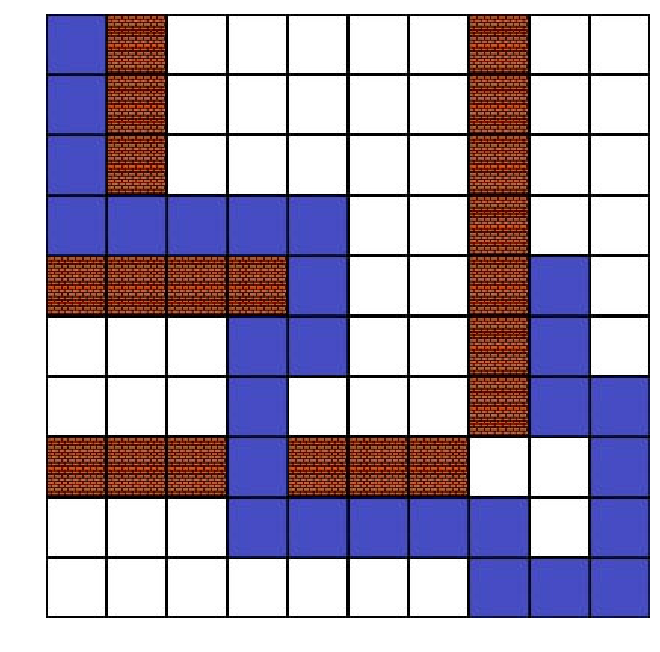

In [49]:
def generateResultMaze(weight):
    myMaze = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    myMaze.fillna(EMPTY, inplace=True)
    row = 0
    column = 0
    key = 0
    maze = generateTestMaze()
    epsilon = 1    
    
    maxLength = 40
    step = 0
    
    #Put in the correct path
    while ((maze.iloc()[row][column] != DOOR) or (key!=1)):
        #Choose action A' from state S' using policy derived from Qw (e.g., epsilon-greedy and Q and w)
        action = epsilon_greedy_Qw(w, row, column, maze, key, epsilon)  
        print("Row: {0:2d}, Column: {1:2d}, Action: {2:5s}, Key: {3}".format(row, column, ACTION_LIST[action], key)) 
        if (action == 0):
            row = max(row - 1, 0)
        elif (action == 1):
            row = min(row + 1, rows_count-1)
        elif (action == 2):
            column = max(column - 1, 0)
        else:
            column = min(column + 1, columns_count-1)
            
        if (maze.iloc()[row][column] == KEY):
            key+=1
            maze.iloc()[row][column] = EMPTY
            
        myMaze.iloc()[row][column] = PATH
        step = step + 1
        
        if (step==maxLength):
            print("Failed to find the exit after walk for {} times".format(step))
            break
    
    #Put in the wall
    for i in range(rows_count):
        for j in range (columns_count):
            if (maze.iloc()[i][j] == WALL):
                myMaze.iloc()[i][j] = WALL                
    return myMaze

resultMaze = generateResultMaze(w)
resultArray = makeImageArray(resultMaze)
showMaze(resultArray)